# 0. Seleção de estratégia de discretização dos *scores* de sentimentos dos comitês de especialistas para comparação com demais algoritmos.

Ao analisar os sentimentos dos algoritmos, os realizamos de forma qualitativa, atribuindo polaridades aos diálogos (negativa, neutra e positiva) e após realizar as rotulações de diálogos, seguindo as instruções da literatura presentes em Kim et al. (2020), determinanos o sentimento final de um diálogo como a média dos sentimentos atribuídos por especialistas (três) humanos componentes de um comitê de avaliação.

Para isso, consideramos os sentimentos sob uma perspectiva quantitativa (numérica), atribuindo valor $-1$ para o sentimento negativo, $0$ para o sentimento neutro e $+1$ para o sentimento positivo, para em sequência, somar as avaliações dos especialistas e dividi-las por três, para calcular a média e usar essa média como sentimento do diálogo (como também para cada expressão contida neste diálogo). Portanto, os sentimentos computados pertencem ao intervalo $\left[-1, 1\right]$

Ao estudar multiplos algoritmos de análise de sentimentos, presentes no *iFeel*, observamos que cada um deles produzem sentimentos em escalas distintas, o que dificulta portanto a comparação com o intervalo que estabelecemos. Felizmente, os autores do *framework* definiram critérios para apontar polaridades dos algoritmos e portanto, torna possível a comparação do desempenho dos algoritmos a partir das polaridades que produzem (negativa, neutra ou positiva) dos sentimentos.

Neste sentido, queremos num primeiro momento, determinar uma estratégia de discretização dos *scores* produzidos pelos comitês para categorizá-los em polaridades e compará-los com os demais algoritmos, de forma que seja possível eleger o algoritmo de análise de sentimentos mais correlacionado aos especialistas humanos, em nível de diálogos (através da análise da força do sentimento de um diálogo --- a partir da agregação de todas suas expressões --- seguindo estratégia proposta por alguns dos autores do *iFeel* com penalização(premiação) fibonacciana dos sentimentos identificados - nossa proposta contribuição) e em nível de expressões, em comparação direta.

Por isso, propomos neste momento, duas estratégias de discretização:

1. Estratégia restritiva:
$$
    \text{polaridade}(\text{sentimento}) = \left\{ {\text{negativo}, \text{sentimento} \lt {-1 \over 3} ; \\ \text{neutro}, {-1 \over 3} \le \text{sentimento} \le {1 \over 3} ; \\ \text{positivo}, \text{sentimento} \gt {1 \over 3} } \right.
$$

1. Estratégia relaxada:
$$
    \text{polaridade}(\text{sentimento}) = \left\{ {\text{negativo}, \text{sentimento} \le {-1 \over 3} ; \\ \text{neutro}, {-1 \over 3} \lt \text{sentimento} \lt {1 \over 3} ; \\ \text{positivo}, \text{sentimento} \ge {1 \over 3} } \right.
$$

Escolheremos a estratégia cuja correlação $\rho$-spearman entre sentimento e qualidade seja maior.

## 0.1 - Carregando diálogos do ConvAI

In [69]:
import pandas as pd
atendimentos_chatbots = pd.read_json('depois.json')

## 0.2 - Aplicando estratégia restritiva para discretização (polarização) dos sentimentos anotados

In [70]:
df_restrito = atendimentos_chatbots.copy()
filtro_negativo_restrito = df_restrito.sentiment < -0.32
inicio_neutro = df_restrito.sentiment >= -0.32
fim_neutro = df_restrito.sentiment <= 0.33
filtro_neutro_restrito = inicio_neutro & fim_neutro
filtro_positivo_restrito = df_restrito.sentiment > 0.33
df_restrito.loc[filtro_negativo_restrito, 'sentiment'] = -1
df_restrito.loc[filtro_neutro_restrito, 'sentiment'] = 0
df_restrito.loc[filtro_positivo_restrito, 'sentiment'] = 1

### 0.2.1 Correlação spearman entre polaridade restrita e qualidade

In [3]:
df_restrito.quality.corr(df_restrito.sentiment, method='spearman')

0.18139246113459112

## 0.3 - Aplicando estratégia relaxada para discretização (polarização) dos sentimentos anotados

In [4]:
df_relaxado = atendimentos_chatbots.copy()
filtro_negativo_relaxado = df_relaxado.sentiment <= -0.32
inicio_neutro = df_relaxado.sentiment > -0.32
fim_neutro = df_relaxado.sentiment < 0.33
filtro_neutro_relaxado = inicio_neutro & fim_neutro
filtro_positivo_relaxado = df_relaxado.sentiment >= 0.33
df_relaxado.loc[filtro_negativo_relaxado, 'sentiment'] = -1
df_relaxado.loc[filtro_neutro_relaxado, 'sentiment'] = 0
df_relaxado.loc[filtro_positivo_relaxado, 'sentiment'] = 1

### 0.3.1 Correlação spearman entre polaridade restrita e qualidade

In [5]:
df_relaxado.quality.corr(df_relaxado.sentiment, method='spearman')

0.18139246113459112

Ao concluir esta comparação verificamos que as estratégias não se diferem, apresentaram a mesma correlação, portanto, vamos aplicar a primeira estratégia para "polarizar" os sentimentos computados pelo comitê

In [71]:
dialogos_sentimentos_polarizados = df_restrito

Com os sentimentos dos diálogos polarizados, agora é hora de submetê-los a análise do ifeel, através de robôs que operam o navegador firefox para fazer upload dos diálogos e baixar o resultado da análise de sentimento deles produzida pelo *iFeel*

# 1. Produção dos arquivos de texto relativos aos diálogos.

Para cada diálogo produziremos três arquivos contendo o diálogo geral (expressões entre humanos e robôs), diálogos dos humanos (apenas expressões ditas pelos humanos) e diálogos dos robôs.

## 1.1 preparativos:

In [72]:
import pdb
import time
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import StaleElementReferenceException

# variaveis auxiliares
login_ifeel = 'dascaniosantos@gmail.com'
senha_ifeel = '123456'
diretorio_corrente = !pwd
diretorio_corrente = diretorio_corrente[0]

# funcoes auxiliares
compilar_mensagens = lambda x: '\n'.join(list(x))

def register(driver):
    driver.get('http://localhost:1210/registerUser')
    # insere o nome, o email e a senha
    nome = driver.find_element(By.XPATH, '//*[@id="name"]')
    nome.click()
    nome.send_keys(login_ifeel)
    email = driver.find_element(By.XPATH, '//*[@id="email"]')
    email.click()
    email.send_keys(login_ifeel)
    email = driver.find_element(By.XPATH, '//*[@id="repeatEmail"]')
    email.click()
    email.send_keys(login_ifeel)
    senha = driver.find_element(By.XPATH, '//*[@id="password"]')
    senha.click()
    senha.send_keys(senha_ifeel)
    senha = driver.find_element(By.XPATH, '//*[@id="repeatPassword"]')
    senha.click()
    senha.send_keys(senha_ifeel)
    register_btn = driver.find_element(By.XPATH, '/html/body/div[1]/div/div[2]/div[2]/div[2]/div/div/div[2]/div/form/div[6]/button[2]')
    register_btn.click()
    time.sleep(2)
    return

def login(driver):
    driver.get('http://localhost:1210/loginUser')
    time.sleep(2)
    email = driver.find_element(
        By.XPATH, '//*[@id="inputSuccess4"]'
    )
    email.click()
    email.send_keys(login_ifeel)
    password = driver.find_element(
        By.XPATH, '//*[@id="inputSuccess5"]'
    )
    password.click()
    password.send_keys(senha_ifeel)
    login_btn = driver.find_element(
        By.XPATH, '/html/body/div[1]/div/div[2]/div[2]/div[1]/div/div/div[2]/form/div[3]/button[2]'
    )
    login_btn.click()
    time.sleep(3)
    return
    
def logout(driver):
    driver.get('http://localhost:1210/logout')
    time.sleep(3)
    return

def stripe_lines(conteudo):
    lines = ''
    for row in conteudo.split('\n'):
        lines += row[0:299] + '\n'
    return lines

def gravar_arquivo (caminho, conteudo):
    f = open(caminho, 'w')
    f.write(stripe_lines(conteudo))
    f.close()
    
def carregar_arquivo(driver, arquivo):
    driver.get('http://localhost:1210/analyseFiles')
    time.sleep(2)
    arquivo_input = driver.find_element(
        By.XPATH, '//*[@id="fileInput"]'
    )
    arquivo_input.send_keys(arquivo)
    time.sleep(2)
    # upload
    driver.find_element(
        By.XPATH, '/html/body/div[1]/div/div[2]/div[4]/div[1]/div/div[2]/form/div[4]/div/button'
    ).click()
    time.sleep(2)
    return
    
def esperar_analise(driver):
    status = ''
    fim_espera = time.time() + 600
    while status != 'Complete' and time.time() < fim_espera:
        try:
            status = driver.find_element(
                By.XPATH, '/html/body/div[1]/div/div[2]/div[4]/div[2]/div/div[2]/table/tbody/tr/td[3]'
            ).text
        except (NoSuchElementException, StaleElementReferenceException):
            status = ''
    time.sleep(4)
    return True if time.time() < fim_espera else False

def baixar_analise(driver, arquivo):
    driver.find_element(
        By.XPATH, '/html/body/div[1]/div/div[2]/div[4]/div[2]/div/div[2]/table/tbody/tr/td[1]/span/a[1]/span'
    ).click()
    time.sleep(2)
    !mv ~/Downloads/iFeelFile.xlsx {arquivo}
    time.sleep(2)
    return

def deletar_dialogo_ifeel(driver):
    driver.find_element(
        By.XPATH, '/html/body/div[1]/div/div[2]/div[4]/div[2]/div/div[2]/table/tbody/tr/td[7]/a'
    ).click()
    time.sleep(8)
    driver.find_element(
        By.XPATH, '/html/body/div[1]/div/div[2]/div[2]/div/div/div/a'
    ).click()
    time.sleep(4)
    return

# opcoes do webdriver
options = webdriver.FirefoxOptions()
'''
    descomente a linha abaixo para executar o navegador
    em modo headless
'''
#options.add_argument('--headless')

# criação das pastas de diálogos e de analises
#!rm -rf dialogos
#!mkdir dialogos 
#!rm -rf analise
#!mkdir analises

'\n    descomente a linha abaixo para executar o navegador\n    em modo headless\n'

## 1.2 gravacao de dialogos em arquivos txt

In [8]:
# iteração sobre cada dialogo
for index, dialogo in dialogos_sentimentos_polarizados.iterrows():
    mensagens = pd.DataFrame(dialogo.thread)
    if not mensagens.empty:
        mensagens_geral = compilar_mensagens(
            mensagens.text
        )
        gravar_arquivo('dialogos/dialogo_{}.txt'.format(index + 1), mensagens_geral) # para processamento imediato
        mensagens_humano = compilar_mensagens(
            mensagens[mensagens.userId == 'Alice'].text
        )
        gravar_arquivo('dialogos/dialogo_{}_mensagens_humano.txt'.format(index + 1), mensagens_humano) # para processamento posterior
        mensagens_robo = compilar_mensagens(
            mensagens[mensagens.userId == 'Bob'].text
        )
        gravar_arquivo('dialogos/dialogo_{}_mensagens_robo.txt'.format(index + 1), mensagens_robo) # para processamento posterior

## 1.3 Robô de submissão de diálogos para avaliação de resultados dos algoritmos do iFeel
### 1.3.1 iniciando o iFeel

In [7]:
!docker stop ifeel_container
!docker start ifeel_container
!docker exec -dt ifeel_container mvn spring-boot:run -Drun.arguments=--spring.profiles.active=docker -Drun.jvmArguments="-Xmx4g"
time.sleep(120) # espera 120 segundos para o ifeel subir

ifeel_container
ifeel_container


### 1.3.2 iniciando o robô

In [10]:
driver = webdriver.Firefox(executable_path = '/usr/bin/geckodriver', options = options)
time.sleep(5)

/tmp/ipykernel_3600/3356001588.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path = '/usr/bin/geckodriver', options = options)


### 1.3.3 registrando usuário

In [11]:
register(driver)

### 1.3.5 submetendo os arquivos de texto ao ifeel para realização das análises

In [12]:
# 1.3.5.1 acessando pagina de analise de arquivos
# 1.3.5.2 iteração sobre cada dialogo
for index, dialogo in list(dialogos_sentimentos_polarizados.iterrows())[432:]:
    mensagens = pd.DataFrame(dialogo.thread)
    if not mensagens.empty:
        #for i in ['', '_mensagens_humano', '_mensagens_robo']:
        # consertar a posteriori - adicionar verificação de arquivo vazio por parte de humanos
        # e robos
        for i in ['']:
            # 1. fazer login no ifeel
            logout(driver)
            login(driver)
            # 2. carregar arquivo no ifeel
            arquivo = diretorio_corrente + '/dialogos/dialogo_{}{}.txt'.format(index + 1, i)
            carregar_arquivo(driver, arquivo)
            # 3. esperar o fim da analise
            sucesso = esperar_analise(driver)
            if sucesso:
                # 4. baixar analise
                arquivo = diretorio_corrente + '/analises/dialogo_{}{}.xlsx'.format(index + 1, i)
                baixar_analise(driver, arquivo)
                # 5. deletar dialogo do ifeel
                deletar_dialogo_ifeel(driver)
            time.sleep(2)
# 5. fecha o driver
driver.close()

### 1.3.6 colocando analises do iFeel e dos especialistas no mesmo formato e salvando este resultado em novo arquivo json

In [73]:
df_restrito = atendimentos_chatbots.copy()
dialogos_sentimentos_polarizados = df_restrito
def polarizar(mensagens, index):
    global bot_eval
    # 2. discretizar avaliacoes
    filtro_negativo_restrito = mensagens.evaluation < -0.32
    inicio_neutro = mensagens.evaluation >= -0.32
    fim_neutro = mensagens.evaluation <= 0.33
    filtro_neutro_restrito = inicio_neutro & fim_neutro
    filtro_positivo_restrito = mensagens.evaluation > 0.33
    mensagens.loc[filtro_negativo_restrito, 'evaluation'] = 'Negative'
    mensagens.loc[filtro_neutro_restrito, 'evaluation'] = 'Neutral'
    mensagens.loc[filtro_positivo_restrito, 'evaluation'] = 'Positive'
    #bot_map = lambda x:\
    #    -1 if x == 'Negative' else 0 if x == 'Neutral' else 1 if x == 'Positive' else 2
    #mensagens['evaluation'] = mensagens['evaluation'].apply(bot_map)
    # 2.1 carregar avaliacoes dos algoritmos de analise de sentimento
    bot_eval = pd.read_excel('analises/dialogo_{}.xlsx'.format(index + 1))
    # 2.2 colocar avaliacoes dos bots nas threads
    bot_eval = bot_eval.drop(columns = ['Original Lines'])
    for method in bot_eval.columns:
        mensagens[method] = bot_eval[method]
    #    mensagens[method] = bot_eval[method].apply(bot_map)
    return mensagens

df = dialogos_sentimentos_polarizados
for index, dialogo in df.iterrows():
    mensagens = pd.DataFrame(dialogo.thread)
    if not mensagens.empty:
        mensagens = polarizar(mensagens, index)
        df.at[index, 'thread'] = mensagens
df.to_json('estudo_algoritmo_analise_sentimentos.json', 'records')
        

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
 

### 1.3.7 Calculando Macro F1 entre avaliadores e algoritmos de análise de sentimento para escolher o mais similar.

In [74]:
from sklearn.metrics import f1_score as f1
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import pearsonr, spearmanr
binarizer = MultiLabelBinarizer()
sa_algorithms = bot_eval.columns
y_true = []
y_preds = {algo: [] for algo in sa_algorithms}
avaliar = 'both'
remover_neutros = False
for index, dialogo in df.iterrows():
    mensagens = pd.DataFrame(dialogo.thread)
    if not mensagens.empty:
        if avaliar == 'humans':
            filtro = mensagens.userId == 'Alice'
        elif avaliar == 'bots':
            filtro = mensagens.userId == 'Bob'
        else:
            filtro = [True for i in range(len(mensagens))]
        if remover_neutros:
            filtro &= mensagens.evaluation != 'Neutro'
        y_true += list(mensagens[filtro].evaluation)
        for algo in sa_algorithms:
            y_preds[algo] += list(mensagens[filtro][algo])


In [75]:
from tabulate import tabulate
max_score = -999999
max_corr = -999999
best_algo_f1 = None
best_algo_spearman = None
results = pd.DataFrame(columns = ['Algorithm', 'Macro F1', 'Spearman r'])
for algo in sa_algorithms:
    score = f1(y_true, y_preds[algo], average='macro')
    spearman, _ = spearmanr(y_true, y_preds[algo])
    results = results.append({
        'Algorithm': algo,
        'Macro F1': score,
        'Spearman r': spearman
    }, ignore_index=True)
    if score > max_score:
        best_algo_f1 = algo
        max_score = score
    if spearman > max_corr:
        best_algo_spearman = algo
        max_corr = spearman

print(
    tabulate(results, headers='keys', tablefmt='psql')
)
print('Algorithm with best Macro F1-Score: {}: {:.2f}'.format(best_algo_f1, max_score))
print('Algorithm with best Spearman\'s rho: {}: {:.2f}'.format(best_algo_spearman, max_corr))

/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


+----+----------------+------------+--------------+
|    | Algorithm      |   Macro F1 |   Spearman r |
|----+----------------+------------+--------------|
|  0 | OPINIONLEXICON |   0.278299 |    0.184066  |
|  1 | SENTISTRENGTH  |   0.320281 |    0.247581  |
|  2 | SOCAL          |   0.305134 |    0.233977  |
|  3 | HAPPINESSINDEX |   0.265173 |    0.162154  |
|  4 | SANN           |   0.281586 |    0.144498  |
|  5 | EMOTICONSDS    |   0.223355 |    0.101104  |
|  6 | SENTIMENT140   |   0.280653 |    0.12382   |
|  7 | STANFORD       |   0.276418 |    0.152049  |
|  8 | AFINN          |   0.32475  |    0.216151  |
|  9 | MPQA           |   0.246027 |    0.159673  |
| 10 | NRCHASHTAG     |   0.232987 |    0.0583321 |
| 11 | EMOLEX         |   0.282785 |    0.136195  |
| 12 | EMOTICONS      |   0.155124 |    0.038902  |
| 13 | PANAST         |   0.15064  |    0.0520729 |
| 14 | SASA           |   0.271044 |    0.137769  |
| 15 | SENTIWORDNET   |   0.304564 |    0.133842  |
| 16 | VADER

/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/1734821125.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


### Matriz de Confusão de predições de Negativos, Neutros e Positivos

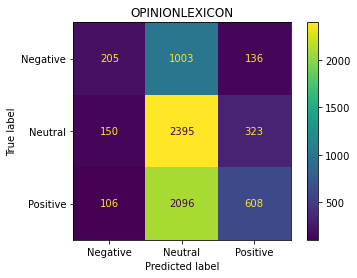

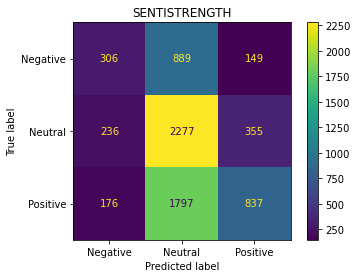

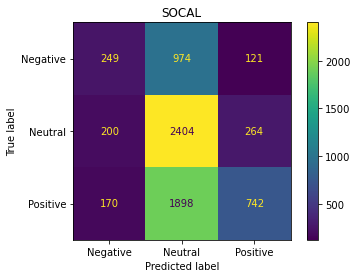

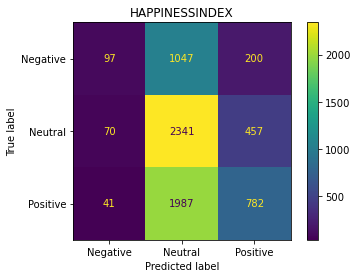

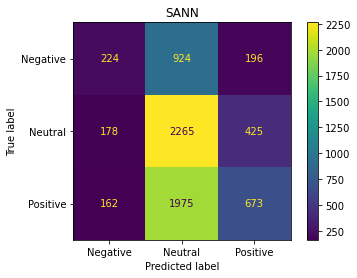

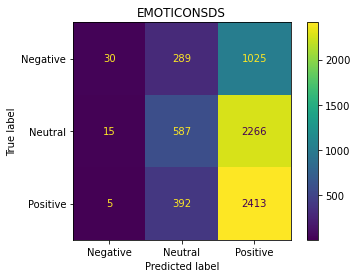

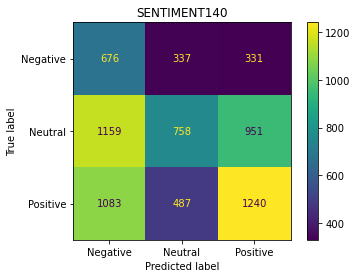

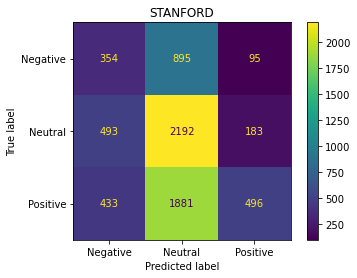

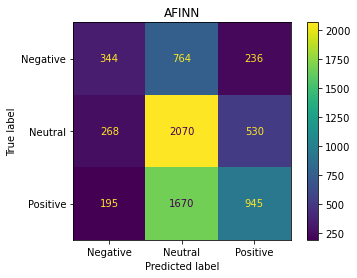

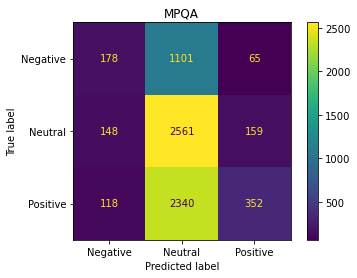

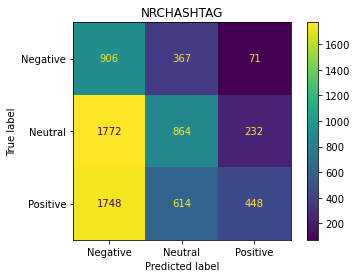

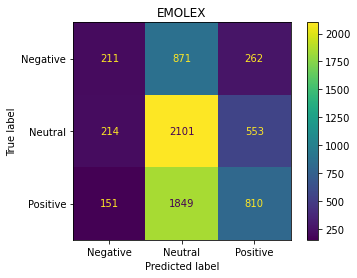

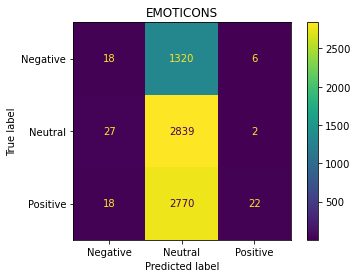

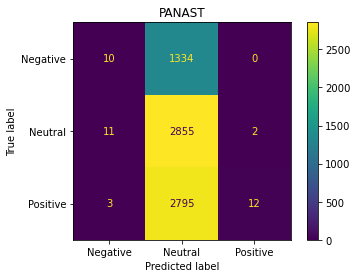

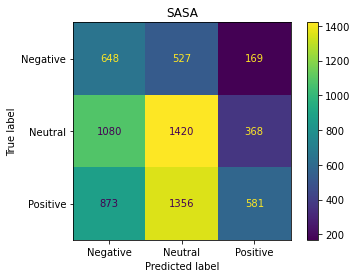

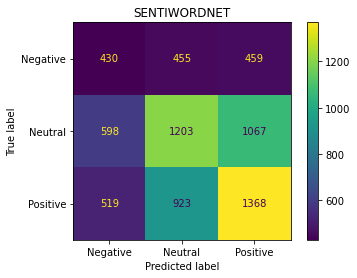

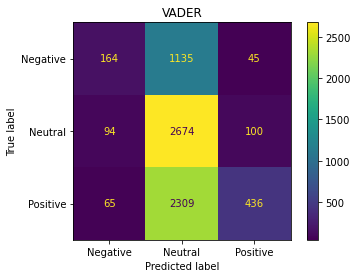

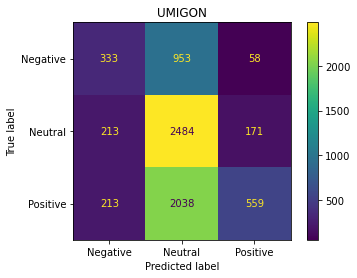

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for algo in sa_algorithms:
    c = confusion_matrix(y_true, y_preds[algo], labels=['Negative', 'Neutral', 'Positive'])
    c_display = ConfusionMatrixDisplay(confusion_matrix = c, display_labels=['Negative', 'Neutral', 'Positive'])
    c_display.plot()
    plt.title(algo)
    plt.show()
    

### Binarizando o problema --- transformando-o em aceitável (neutros e positivos) e inaceitável - negativos

In [81]:
from copy import copy
binario = copy(y_preds)
binario['expert'] = copy(y_true)
binario = pd.DataFrame(binario)
inaceitavel = binario == 'Negative'
binario[~inaceitavel] = 1
binario[inaceitavel] = 0

### Calculando F1 Score do Problema Binarizado

In [82]:
from tabulate import tabulate
max_score = -999999
best_algo_f1 = None
results = pd.DataFrame(columns = ['Algorithm', 'Macro F1'])
expert = copy(binario['expert'])
print(expert.values)
del(binario['expert'])
for method in binario:
    score = f1(list(expert), list(binario[method]), average='macro')
    results = results.append({
        'Algorithm': method,
        'Macro F1': score,
    }, ignore_index=True)
    if score > max_score:
        best_algo_f1 = method
        max_score = score

print(
    tabulate(results, headers='keys', tablefmt='psql')
)
print('Algorithm with best Macro F1-Score: {}: {:.2f}'.format(best_algo_f1, max_score))

[1 0 1 ... 1 1 1]


/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


+----+----------------+------------+
|    | Algorithm      |   Macro F1 |
|----+----------------+------------|
|  0 | OPINIONLEXICON |   0.556522 |
|  1 | SENTISTRENGTH  |   0.587824 |
|  2 | SOCAL          |   0.566153 |
|  3 | HAPPINESSINDEX |   0.508104 |
|  4 | SANN           |   0.557191 |
|  5 | EMOTICONSDS    |   0.468776 |
|  6 | SENTIMENT140   |   0.509917 |
|  7 | STANFORD       |   0.550992 |
|  8 | AFINN          |   0.598349 |
|  9 | MPQA           |   0.541079 |
| 10 | NRCHASHTAG     |   0.418008 |
| 11 | EMOLEX         |   0.548065 |
| 12 | EMOTICONS      |   0.458538 |
| 13 | PANAST         |   0.454132 |
| 14 | SASA           |   0.533133 |
| 15 | SENTIWORDNET   |   0.557663 |
| 16 | VADER          |   0.544228 |
| 17 | UMIGON         |   0.598103 |
+----+----------------+------------+
Algorithm with best Macro F1-Score: AFINN: 0.60


/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_6491/2883731009.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


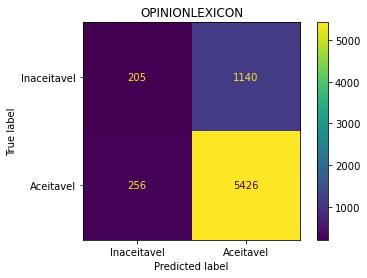

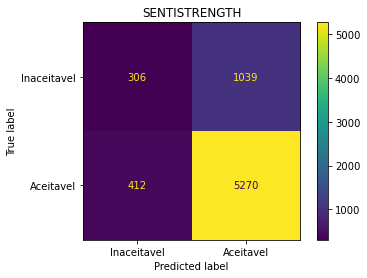

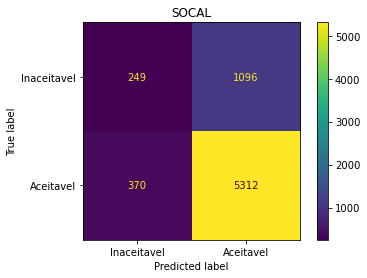

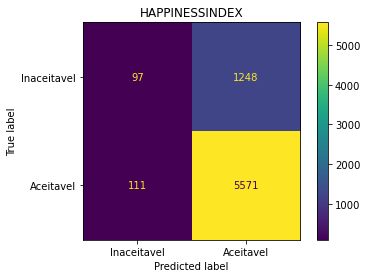

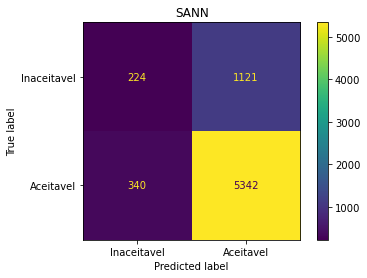

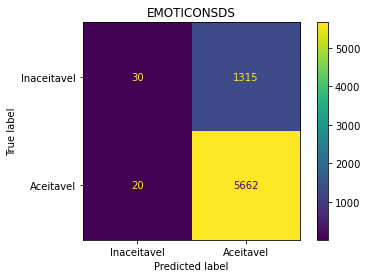

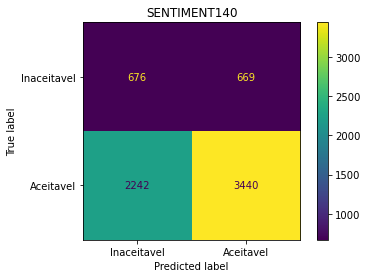

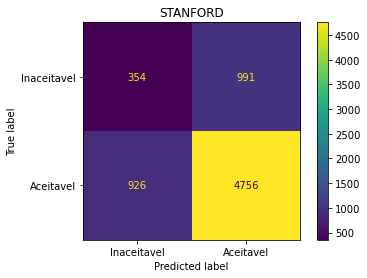

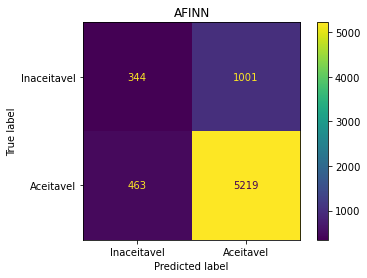

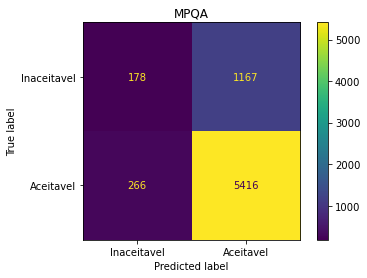

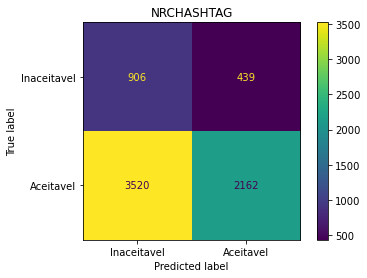

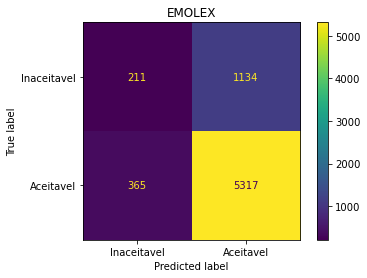

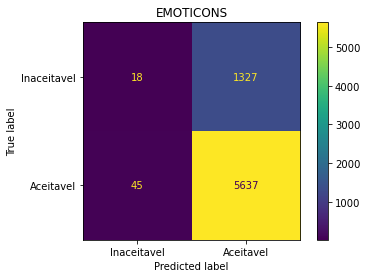

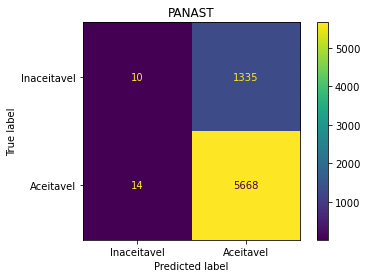

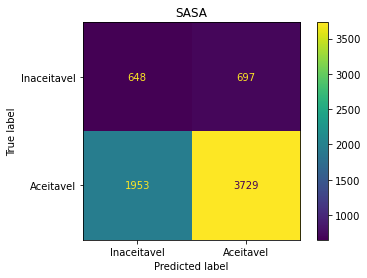

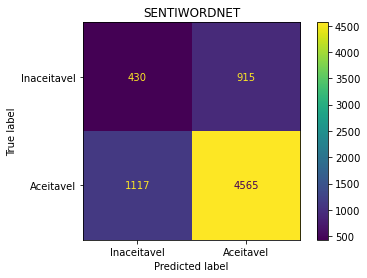

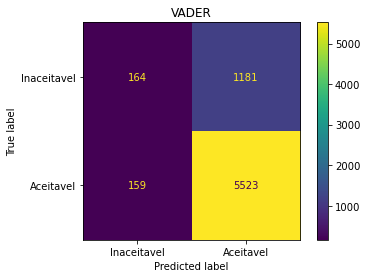

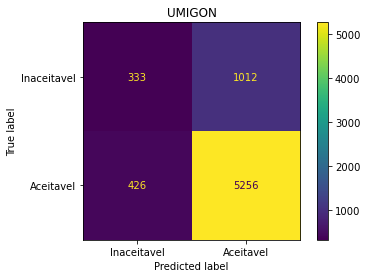

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for algo in sa_algorithms:
    c = confusion_matrix(list(expert), list(binario[algo]))
    c_display = ConfusionMatrixDisplay(confusion_matrix = c, display_labels = ['Inaceitavel', 'Aceitavel'])
    c_display.plot()
    plt.title(algo)
    plt.show()